## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import tensorflow as tf
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l1_l2_use=False):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    if l1_l2_use:
        regularizer = l1_l2(l1_ratio)
    else:
        regularizer = l1(l1_ratio)
            
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regularizer)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regularizer)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-6, 1e-8]
L1_L2 = [True, False]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for bl1_l2 in L1_L2:
    for regulizer_ratio in L1_EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with %s Regulizer = %.8f" % ("L1_L2" if bl1_l2 else "L1", regulizer_ratio))
        model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio, l1_l2_use=bl1_l2)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "exp-l1-%s-%s" % (str(regulizer_ratio), bl1_l2)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with L1_L2 Regulizer = 0.01000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/500

Epoch 49/50
50000/50000 [==============================] - 4s 72us/step - loss: 2.4614 - accuracy: 0.0983 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 4s 78us/step - loss: 2.4614 - accuracy: 0.0973 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with L1_L2 Regulizer = 0.00010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________________

Epoch 47/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.7597 - accuracy: 0.4789 - val_loss: 1.7717 - val_accuracy: 0.4712
Epoch 48/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.7548 - accuracy: 0.4789 - val_loss: 1.7799 - val_accuracy: 0.4742
Epoch 49/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.7524 - accuracy: 0.4786 - val_loss: 1.7993 - val_accuracy: 0.4552
Epoch 50/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7484 - accuracy: 0.4810 - val_loss: 1.7873 - val_accuracy: 0.4654
Experiment with L1_L2 Regulizer = 0.00000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_______________

Epoch 45/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.6341 - accuracy: 0.5156 - val_loss: 1.7422 - val_accuracy: 0.4852
Epoch 46/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.6302 - accuracy: 0.5179 - val_loss: 1.6837 - val_accuracy: 0.4914
Epoch 47/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.6268 - accuracy: 0.5194 - val_loss: 1.7114 - val_accuracy: 0.4871
Epoch 48/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.6249 - accuracy: 0.5191 - val_loss: 1.7065 - val_accuracy: 0.4801
Epoch 49/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.6181 - accuracy: 0.5228 - val_loss: 1.6667 - val_accuracy: 0.5025
Epoch 50/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.6145 - accuracy: 0.5241 - val_loss: 1.6787 - val_accuracy: 0.4905
Experiment with L1_L2 Regulizer = 0.00000001
Model: "model_1"
__________________________________________________

Epoch 43/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.6417 - accuracy: 0.5137 - val_loss: 1.7703 - val_accuracy: 0.4642
Epoch 44/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.6365 - accuracy: 0.5154 - val_loss: 1.6909 - val_accuracy: 0.4914
Epoch 45/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.6302 - accuracy: 0.5170 - val_loss: 1.6894 - val_accuracy: 0.4979
Epoch 46/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.6262 - accuracy: 0.5185 - val_loss: 1.6739 - val_accuracy: 0.4987
Epoch 47/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.6233 - accuracy: 0.5194 - val_loss: 1.6839 - val_accuracy: 0.4944
Epoch 48/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.6161 - accuracy: 0.5223 - val_loss: 1.7381 - val_accuracy: 0.4711
Epoch 49/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.6149 - accuracy: 0.5210 - val_

Epoch 41/50
50000/50000 [==============================] - 5s 106us/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 5s 106us/step - loss: 2.4626 - accuracy: 0.0968 - val_loss: 2.4623 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 5s 99us/step - loss: 2.4626 - accuracy: 0.0990 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 5s 95us/step - loss: 2.4626 - accuracy: 0.0971 - val_loss: 2.4623 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 4s 87us/step - loss: 2.4626 - accuracy: 0.0986 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 4s 84us/step - loss: 2.4626 - accuracy: 0.0986 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 4s 85us/step - loss: 2.4626 - accuracy: 0.0981 - va

Epoch 39/50
50000/50000 [==============================] - 4s 76us/step - loss: 3.0816 - accuracy: 0.6103 - val_loss: 3.3615 - val_accuracy: 0.5067
Epoch 40/50
50000/50000 [==============================] - 4s 73us/step - loss: 3.0309 - accuracy: 0.6144 - val_loss: 3.2574 - val_accuracy: 0.5239
Epoch 41/50
50000/50000 [==============================] - 4s 72us/step - loss: 2.9872 - accuracy: 0.6165 - val_loss: 3.3940 - val_accuracy: 0.4733
Epoch 42/50
50000/50000 [==============================] - 4s 74us/step - loss: 2.9424 - accuracy: 0.6194 - val_loss: 3.1683 - val_accuracy: 0.5341
Epoch 43/50
50000/50000 [==============================] - 4s 70us/step - loss: 2.9008 - accuracy: 0.6214 - val_loss: 3.1460 - val_accuracy: 0.5286
Epoch 44/50
50000/50000 [==============================] - 4s 71us/step - loss: 2.8584 - accuracy: 0.6231 - val_loss: 3.1854 - val_accuracy: 0.5015
Epoch 45/50
50000/50000 [==============================] - 3s 70us/step - loss: 2.8171 - accuracy: 0.6249 - val_

Epoch 37/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.0782 - accuracy: 0.6361 - val_loss: 1.4374 - val_accuracy: 0.5130
Epoch 38/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.0640 - accuracy: 0.6414 - val_loss: 1.4074 - val_accuracy: 0.5276
Epoch 39/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.0503 - accuracy: 0.6457 - val_loss: 1.4415 - val_accuracy: 0.5182
Epoch 40/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.0402 - accuracy: 0.6484 - val_loss: 1.4233 - val_accuracy: 0.5195
Epoch 41/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.0272 - accuracy: 0.6531 - val_loss: 1.4244 - val_accuracy: 0.5247
Epoch 42/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.0151 - accuracy: 0.6574 - val_loss: 1.4158 - val_accuracy: 0.5236
Epoch 43/50
50000/50000 [==============================] - 5s 105us/step - loss: 1.0038 - accuracy: 0.6639 - val

50000/50000 [==============================] - 5s 98us/step - loss: 1.0716 - accuracy: 0.6238 - val_loss: 1.3827 - val_accuracy: 0.5190
Epoch 35/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.0568 - accuracy: 0.6270 - val_loss: 1.3262 - val_accuracy: 0.5349
Epoch 36/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.0471 - accuracy: 0.6315 - val_loss: 1.3381 - val_accuracy: 0.5314
Epoch 37/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.0320 - accuracy: 0.6372 - val_loss: 1.3172 - val_accuracy: 0.5414
Epoch 38/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.0208 - accuracy: 0.6431 - val_loss: 1.3471 - val_accuracy: 0.5347
Epoch 39/50
50000/50000 [==============================] - 4s 83us/step - loss: 1.0081 - accuracy: 0.6451 - val_loss: 1.3463 - val_accuracy: 0.5327
Epoch 40/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.9923 - accuracy: 0.6510 - val_loss: 1.349

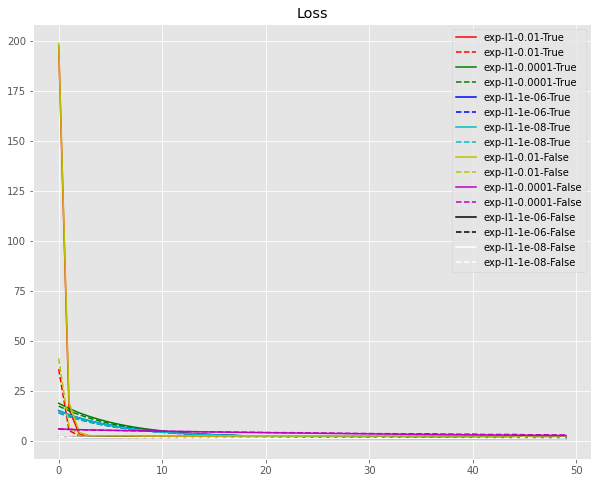

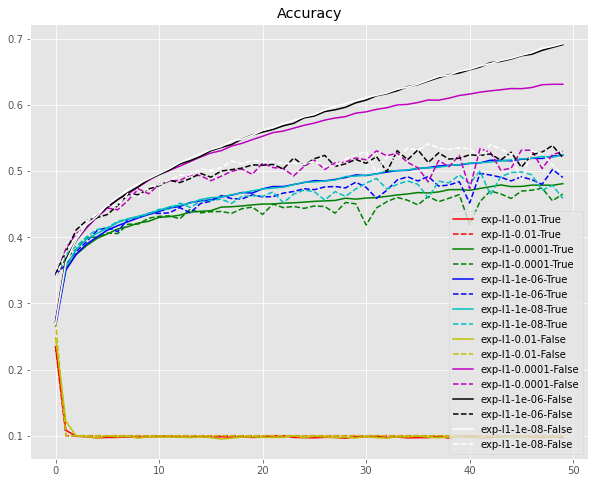

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
"""Code Here
將結果繪出
"""
    
# NUM_COLORS = len(results.keys())
# cm = plt.get_cmap('gist_rainbow')
# color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
color_bar = ["r", "g", "b", "c", "y", "m", "k", "w"]

plt.figure(figsize=(10,8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()